# Análise de séries temporais

## Entendendo o problema

Uma rede de restaurantes está com dificuldades em realizar o planejamento do negócio como um todo. A percepção é de que em alguns dias o movimento é muito baixo, fazendo com que os garçons fiquem muito ociosos. Em outros dias, o movimento é muito alto, e a quantidade de garçons parece ser insuficiente para atender a todas as pessoas.

Vamos realizar uma análise nos dados de **quantidade de clientes por dia nos restaurantes** para melhorar o planejamento de atendimento na rede de restaurantes.

### Fazendo a leitura dos dados

O primeiro passo é fazer a leitura da base de dados, a partir do arquivo `qtd_clientes_restaurantes.csv`. Vamos fazer a leitura com a função [`read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) da biblioteca `pandas`.

In [58]:
#Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [2]:
dados = pd.read_csv('clientes_restaurantes.csv')

O `DataFrame` apresenta informações de data e quantidade de clientes de dois restaurantes ao longo dos dias, o **Chimi & Churri** e o **Assa Frão**. Precisamos fazer uma análise desses dados de restaurante para aprimorar o planejamento da quantidade de garçons que precisam ser alocados em cada dia.

Vamos ver algumas informações adicionais dos dados, como presença de dados nulos e tipos de dados em cada coluna, usando o método [`info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html).

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   data            478 non-null    object 
 1   Chimi & Churri  476 non-null    float64
 2   Assa Frão       477 non-null    float64
dtypes: float64(2), object(1)
memory usage: 11.3+ KB


A coluna `data` é do tipo `object`, portanto está sendo entendida como um texto. Vamos aplicar uma transformação da coluna para o formato `datetime` e definir essa informação como o índice do `DataFrame`.

In [4]:
dados['data'] = pd.to_datetime(dados['data'])
dados.set_index('data', inplace=True)
dados.head()

,Chimi & Churri,Assa Frão
data,,
2016-01-01,65.0,139.0
2016-01-02,24.0,85.0
2016-01-03,24.0,81.0
2016-01-04,23.0,32.0
2016-01-05,2.0,43.0


In [5]:
dados['Chimi & Churri'][dados['Chimi & Churri'].isna()]

data
2016-04-05   NaN
2016-09-17   NaN
Name: Chimi & Churri, dtype: float64

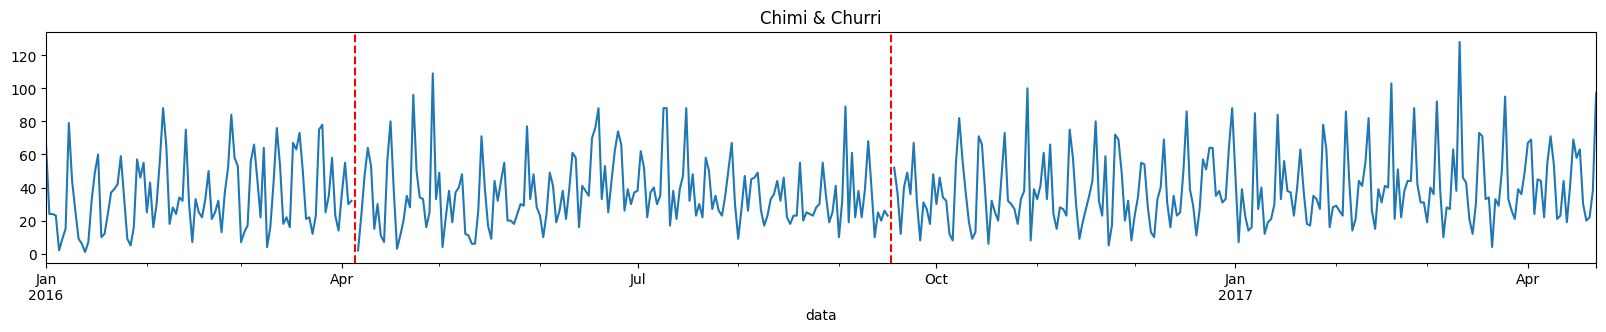

In [6]:
dados['Chimi & Churri'].plot(figsize=(20, 3), title='Chimi & Churri')
plt.axvline(x = dados['Chimi & Churri'][dados['Chimi & Churri'].isna()].index[0], color='red', linestyle='--')
plt.axvline(x = dados['Chimi & Churri'][dados['Chimi & Churri'].isna()].index[1], color='red', linestyle='--')
plt.show()

In [7]:
dados['Assa Frão'][dados['Assa Frão'].isna()]

data
2016-11-24   NaN
Name: Assa Frão, dtype: float64

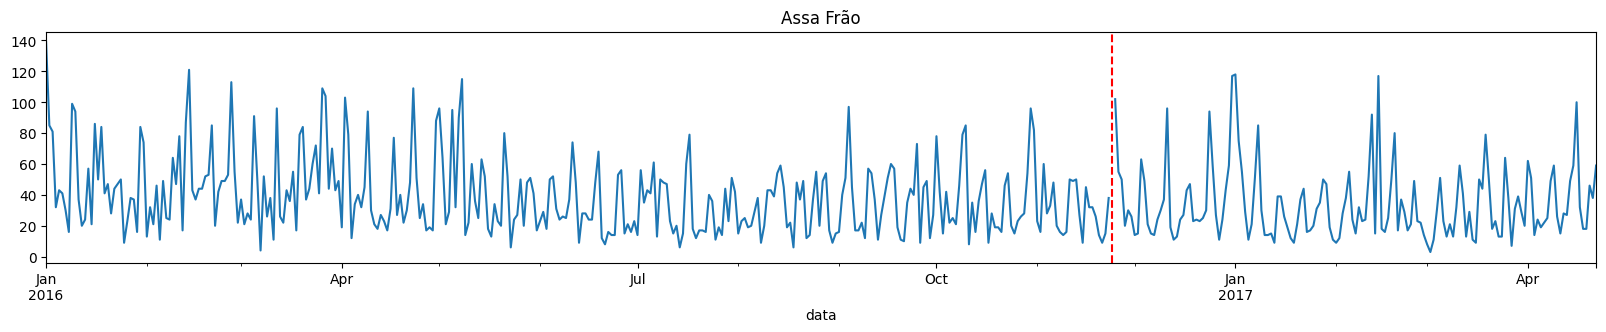

In [8]:
dados['Assa Frão'].plot(figsize=(20, 3), title='Assa Frão')
plt.axvline(x = dados['Assa Frão'][dados['Assa Frão'].isna()].index[0], color='red', linestyle='--')

### Tratando dados nulos

Melhor opção: procurar o setor responsável por alimentar a base de dados para verificar se é possível recuperar essa informação de alguma forma e preencher o valor na base de dados.

Caso não seja possível, de acordo com cada caso, podemos utilizar alguma estratégia de preenchimento dos dados ou remover o registro da base de dados somente no momento de análise. As estratégias mais usuais seriam:

- Preenchimento do dado nulo com a média/mediana/moda da variável.

Em séries temporais:

- Preencher com o valor anterior
- Preencher com o valor posterior
- Preencher com o ponto médio do valor anterior e posterior

In [9]:
dados = dados.interpolate() 

A função `interpolate()` do pandas preenche valores nulos (NaN) em um DataFrame ou Series utilizando interpolação. Ou seja, ela estima os valores ausentes com base nos valores vizinhos, seguindo um método escolhido (por padrão, linear). Em séries temporais, isso normalmente significa calcular o valor faltante como o ponto médio entre o valor anterior e o posterior.

In [10]:
dados.loc['2016-04-04':'2016-04-06']

,Chimi & Churri,Assa Frão
data,,
2016-04-04,32.0,12.0
2016-04-05,17.0,34.0
2016-04-06,2.0,40.0


In [11]:
dados.loc['2016-09-16':'2016-09-18']

,Chimi & Churri,Assa Frão
data,,
2016-09-16,23.0,51.0
2016-09-17,37.5,60.0
2016-09-18,52.0,57.0


## Explorando os dados

### Visualizando a distribuição com histograma

Agora que temos todos os dados tratados, podemos começar a analisar os dados dos restaurantes. A primeira análise que podemos fazer é entender como é a distribuição da quantidade de clientes em cada restaurante. Qual é a quantidade de clientes mais comum e menos comum?

In [12]:
dados = dados.astype('int')

<Axes: title={'center': 'Distribuição dos dados do Chimi & Churri'}, ylabel='Frequency'>

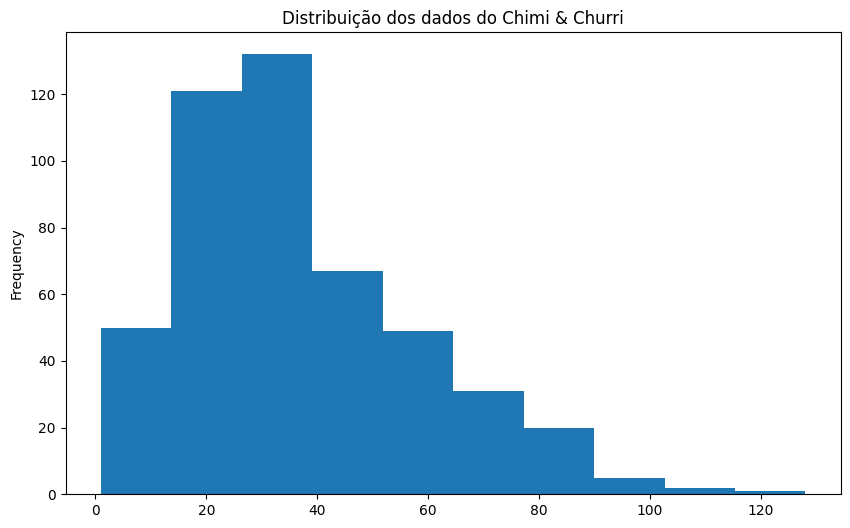

In [13]:
dados['Chimi & Churri'].plot(kind = 'hist',  figsize=(10, 6),title='Distribuição dos dados do Chimi & Churri')

<Axes: title={'center': 'Distribuição dos dados do Assa Frão'}, ylabel='Frequency'>

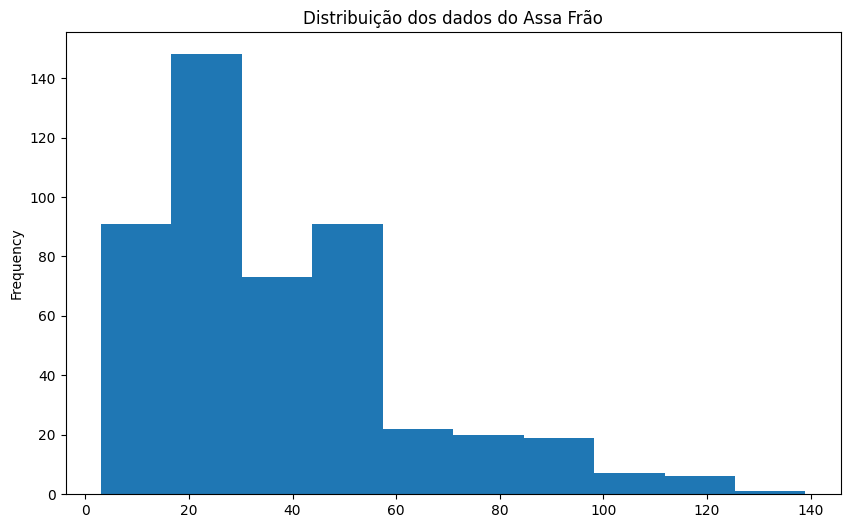

In [14]:
dados['Assa Frão'].plot(kind = 'hist', figsize=(10, 6), title='Distribuição dos dados do Assa Frão')

### Visualizando a distribuição com boxplot

Agora que temos uma ideia mais geral de como se comporta a distribuição da quantidade de clientes nos restaurantes, vamos explorar mais detalhadamente algumas estatísticas a respeito dos dados. Qual a quantidade mínima e máxima de clientes de cada restaurante e qual o valor médio de clientes? Será que existem dias com valores muito discrepantes?

In [15]:
dados.describe()

,Chimi & Churri,Assa Frão
count,478.000000,478.000000
mean,37.451883,37.679916
std,21.433061,24.619708
min,1.000000,3.000000
25%,22.250000,19.000000
50%,33.000000,30.500000
75%,49.000000,50.000000
max,128.000000,139.000000


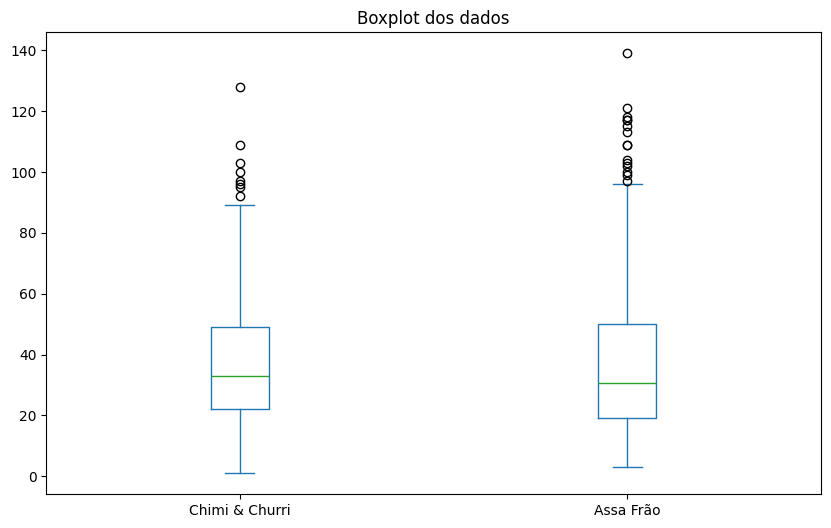

In [16]:
dados.plot(kind='box', figsize=(10, 6), title='Boxplot dos dados')
plt.show()

## Extraindo insights

### Contabilizando o total de clientes

Fizemos uma exploração de estatísticas descritivas dos dois restaurantes e conseguimos encontrar a quantidade de clientes mais frequente, o valor mínimo e máximo de clientes que frequentam cada um dos restaurantes. Seria interessante ter essa mesma análise considerando a rede de restaurantes como um todo, contendo a quantidade de clientes total dia após dia.

In [17]:
dados.head()

,Chimi & Churri,Assa Frão
data,,
2016-01-01,65,139
2016-01-02,24,85
2016-01-03,24,81
2016-01-04,23,32
2016-01-05,2,43


No pandas, o parâmetro axis define a direção da operação:

axis=0 (padrão): a operação é feita por coluna (de cima para baixo).
Exemplo: dados.sum(axis=0) soma todos os valores de cada coluna, ou seja, retorna o total de clientes de cada restaurante.

axis=1: a operação é feita por linha (da esquerda para a direita).

In [18]:
dados['total_clientes'] =dados.sum(axis=1)
dados.head()

,Chimi & Churri,Assa Frão,total_clientes
data,,,
2016-01-01,65,139,204
2016-01-02,24,85,109
2016-01-03,24,81,105
2016-01-04,23,32,55
2016-01-05,2,43,45


<Axes: title={'center': 'Total de Clientes'}, ylabel='Frequency'>

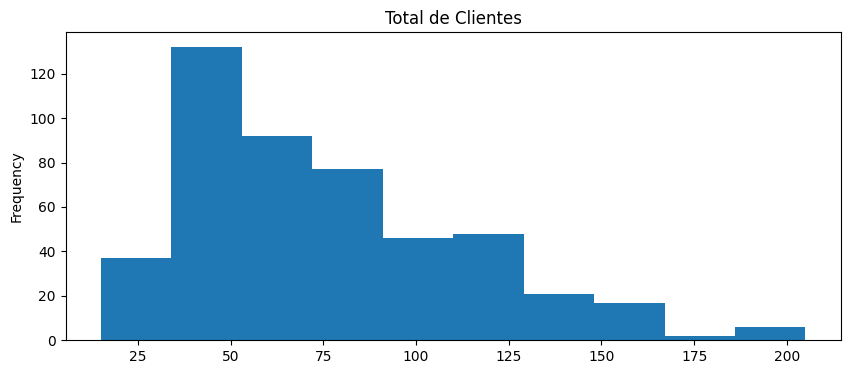

In [19]:
dados['total_clientes'].plot(kind='hist', figsize=(10, 4), title='Total de Clientes')

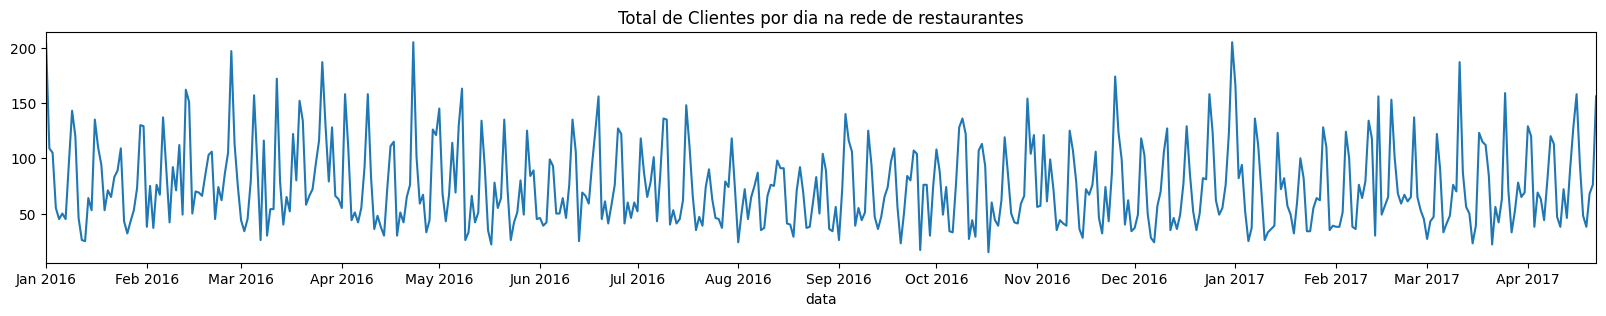

In [20]:
ax = dados['total_clientes'].plot(figsize=(20, 3), title='Total de Clientes por dia na rede de restaurantes')
ax.xaxis.set_major_locator(dates.MonthLocator()) # localiza os meses
ax.xaxis.set_major_formatter(dates.DateFormatter('%b %Y')) # formata a data

Em alguns dias, temos uma quantidade baixa de clientes, e logo após, em um período curto, uma quantidade muito alta de clientes. Isso sempre acontece com o passar do tempo: por pequenos períodos, há uma abundância de clientes e, igualmente, uma queda de clientes. Dessa forma, é difícil analisar como se dá o crescimento ou o decrescimento da quantidade de clientes ao longo do tempo.

### Encontrando a quantidade de clientes mensais

Os dados apresentam a quantidade de clientes por dias nos restaurantes e a partir da visualização da série temporal fica muito difícil entender como está o movimento do restaurante ao longo de cada mês. Vamos fazer um **agrupamento** dos dados e entender se existe uma diferença da quantidade de clientes em cada mês.

In [21]:
clientes_mensais = dados[['Chimi & Churri', 'Assa Frão']].resample(rule='ME').sum()
display(clientes_mensais)

,Chimi & Churri,Assa Frão
data,,
2016-01-31,920,1577
2016-02-29,1109,1396
2016-03-31,1177,1513
2016-04-30,1089,1229
2016-05-31,957,1338
2016-06-30,1262,914
2016-07-31,1299,986
2016-08-31,972,944
2016-09-30,1037,1084


In [22]:
clientes_mensais['mes'] = clientes_mensais.index.month_name(locale = 'pt_BR')
clientes_mensais

,Chimi & Churri,Assa Frão,mes
data,,,
2016-01-31,920,1577,Janeiro
2016-02-29,1109,1396,Fevereiro
2016-03-31,1177,1513,Março
2016-04-30,1089,1229,Abril
2016-05-31,957,1338,Maio
2016-06-30,1262,914,Junho
2016-07-31,1299,986,Julho
2016-08-31,972,944,Agosto
2016-09-30,1037,1084,Setembro


C:\Users\mborges\AppData\Local\Temp\ipykernel_21324\2381784081.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_minor_formatter(ticker.FixedFormatter(['\n\n2016', '\n\n2017']))


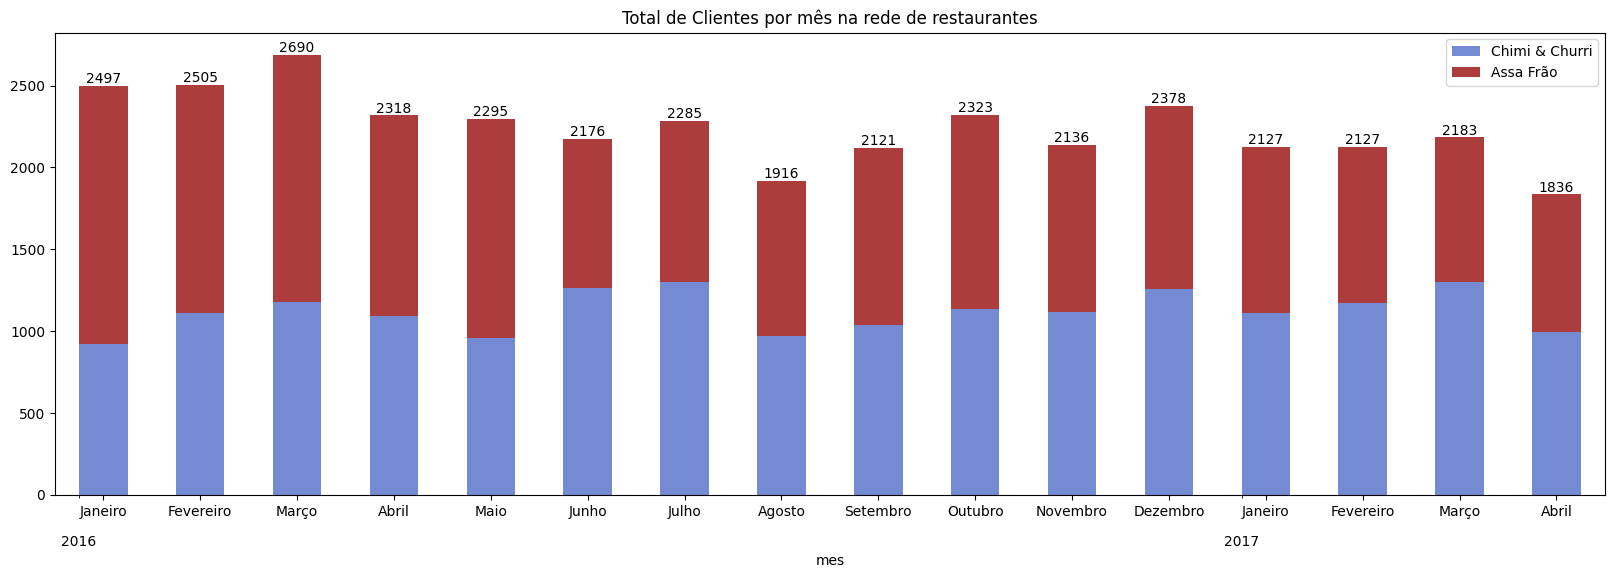

In [23]:
ax = clientes_mensais.plot(x='mes', kind = 'bar', stacked = True, color=["#748AD3", "#AD3D3D"], figsize=(20, 6), rot=0, title='Total de Clientes por mês na rede de restaurantes')
ax.bar_label(ax.containers[1], fontsize = 10)
ax.xaxis.set_minor_locator(ticker.IndexLocator(12,0))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(['\n\n2016', '\n\n2017']))

### Extraindo a média móvel

Analisar apenas o gráfico da série temporal para entender as tendências de crescimento ou decrescimento da série temporal pode ser um pouco difícil. Vamos extrair a média móvel da série para entender o comportamento da série temporal ao longo do período.

In [24]:
for restaurante in ['Chimi & Churri', 'Assa Frão']:
    dados[f'{restaurante}_MM7'] = dados[restaurante].rolling(window=7).mean()

dados

,Chimi & Churri,Assa Frão,total_clientes,Chimi & Churri_MM7,Assa Frão_MM7
data,,,,,
2016-01-01,65,139,204,NaN,NaN
2016-01-02,24,85,109,NaN,NaN
2016-01-03,24,81,105,NaN,NaN
2016-01-04,23,32,55,NaN,NaN
2016-01-05,2,43,45,NaN,NaN
...,...,...,...,...,...
2017-04-18,30,18,48,46.285714,44.714286
2017-04-19,20,18,38,42.857143,43.285714
2017-04-20,22,46,68,43.285714,46.000000


Não precisamos nos preocupar com os resultados nulos (NaN) no início das colunas, pois como precisamos de 7 dias para calcular a média, os primeiros valores não estarão disponíveis na série temporal.

In [25]:
px.line(dados,
        x = dados.index,
        y = ['Chimi & Churri_MM7', 'Assa Frão_MM7'],
        width = 1150,
        height = 400,
        title = 'Média móvel de 7 dias da quantidade de clientes na rede de restaurantes')

### Analisando a média móvel como tendência

Conseguimos comparar a média móvel entre os dois restaurantes e entender a diferença entre a tendência de cada um deles. Agora vamos visualizar como se comporta a média móvel em relação a série temporal original.

<Axes: title={'center': 'Chimi & Churri'}, xlabel='data'>

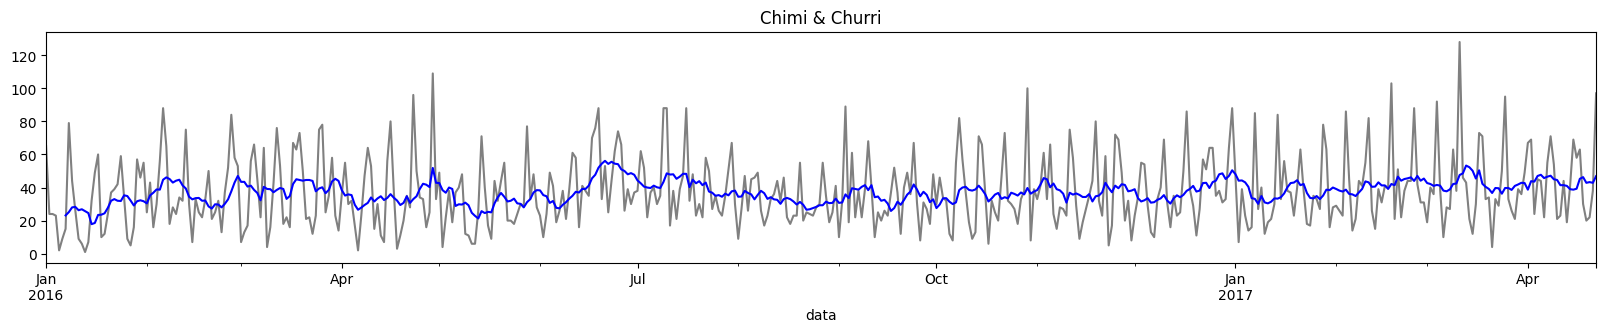

In [26]:
dados['Chimi & Churri'].plot(color = 'gray', figsize=(20, 3), title='Chimi & Churri')
dados['Chimi & Churri_MM7'].plot(color = 'blue', figsize=(20, 3), title='Chimi & Churri')

<Axes: title={'center': 'Assa Frão'}, xlabel='data'>

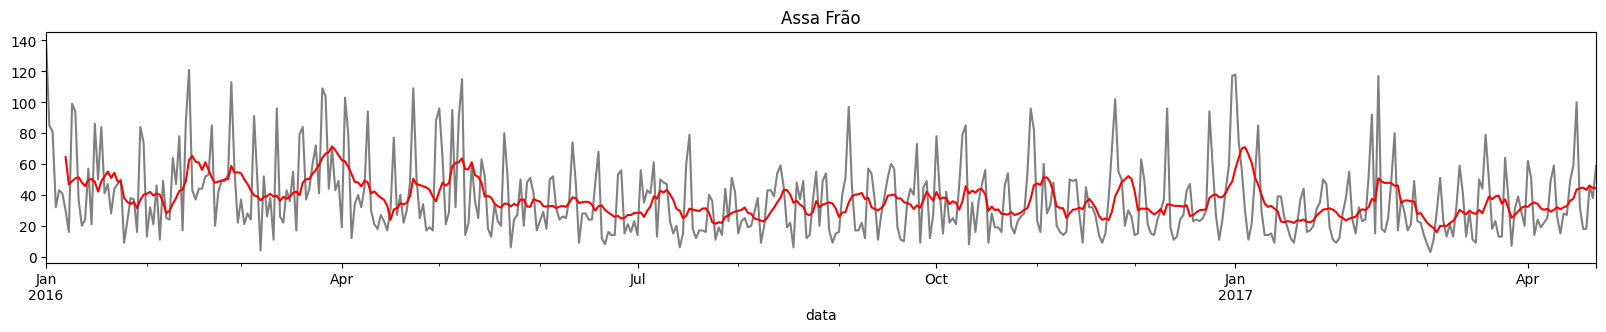

In [27]:
dados['Assa Frão'].plot(color = 'gray', figsize=(20, 3), title='Assa Frão')
dados['Assa Frão_MM7'].plot(color = 'red', figsize=(20, 3), title='Assa Frão')

A média móvel é uma técnica que suaviza as flutuações de curto prazo e destaca tendências de longo prazo

## Detectando anomalias

Anomalias são pontos que se comportam de forma diferente ao padrão geral dos dados. Detectar anomalias é muito importante para encontrar possíveis problemas ou pontos de melhoria dentro do negócio.

Vamos procurar por pontos discrepantes e identificar se as datas em que ocorrem são específicas para que algo possa ser feito com base nessa informação.

### Encontrando dia da semana e datas comemorativas

Vamos extrair o nome do dia da semana e fazer a leitura de uma base de dados de datas comemorativas para complementar a informação que temos na base de dados.

In [28]:
dados.index.day_name(locale = 'pt_BR')

Index(['Sexta-feira', 'Sábado', 'Domingo', 'Segunda-feira', 'Terça-feira',
       'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo',
       ...
       'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo', 'Segunda-feira',
       'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado'],
      dtype='object', name='data', length=478)

In [29]:
dados['dia_semana'] = dados.index.day_name(locale = 'pt_BR')

In [30]:
datas_comemorativas = pd.read_csv('datas_comemorativas.csv')
datas_comemorativas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   data     17 non-null     object
 1   feriado  17 non-null     object
dtypes: object(2)
memory usage: 404.0+ bytes


In [31]:
datas_comemorativas['data'] = pd.to_datetime(datas_comemorativas['data'])
datas_comemorativas.set_index('data', inplace=True)

In [32]:
datas_comemorativas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17 entries, 2016-01-01 to 2017-04-17
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feriado  17 non-null     object
dtypes: object(1)
memory usage: 272.0+ bytes


In [33]:
dados = pd.merge(dados, datas_comemorativas, how = 'left', left_index=True, right_index=True)
dados

,Chimi & Churri,Assa Frão,total_clientes,Chimi & Churri_MM7,Assa Frão_MM7,dia_semana,feriado
data,,,,,,,
2016-01-01,65,139,204,NaN,NaN,Sexta-feira,Ano novo
2016-01-02,24,85,109,NaN,NaN,Sábado,NaN
2016-01-03,24,81,105,NaN,NaN,Domingo,NaN
2016-01-04,23,32,55,NaN,NaN,Segunda-feira,NaN
2016-01-05,2,43,45,NaN,NaN,Terça-feira,NaN
...,...,...,...,...,...,...,...
2017-04-18,30,18,48,46.285714,44.714286,Terça-feira,NaN
2017-04-19,20,18,38,42.857143,43.285714,Quarta-feira,NaN
2017-04-20,22,46,68,43.285714,46.000000,Quinta-feira,NaN


In [34]:
def detectar_anomalias(coluna):
    dados['zscore'] = zscore(dados[coluna])
    anomalias = dados[(dados['zscore'] > 3) | (dados['zscore'] < -3)]
    return anomalias[[coluna, 'zscore', 'dia_semana', 'feriado']]

anomalias_chimi_churri = detectar_anomalias('Chimi & Churri')
anomalias_assa_frao = detectar_anomalias('Assa Frão')

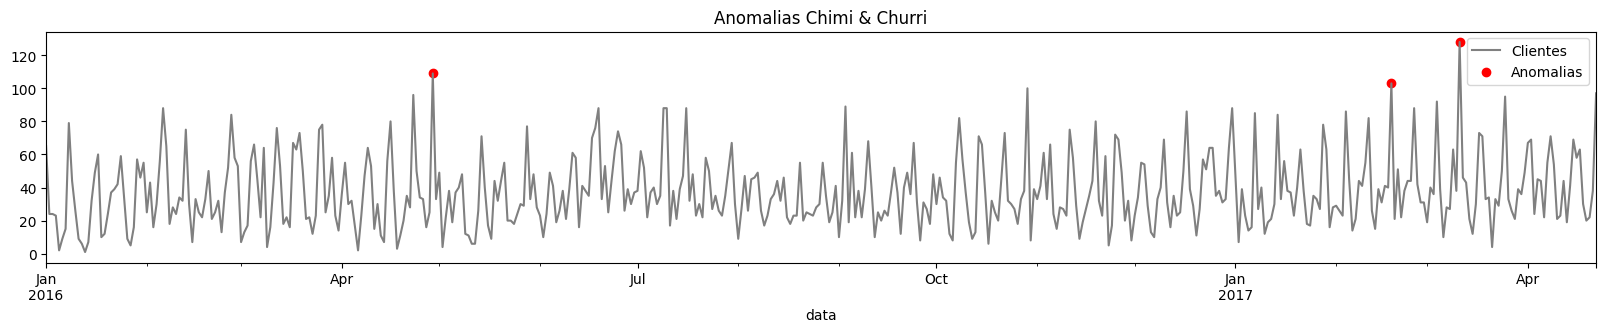

In [35]:
ax = dados['Chimi & Churri'].plot(label = 'Clientes', color = 'gray', figsize=(20, 3), title='Chimi & Churri')
ax.scatter(anomalias_chimi_churri.index.to_pydatetime(), anomalias_chimi_churri['Chimi & Churri'], color = 'red', label = 'Anomalias')
ax.set_title('Anomalias Chimi & Churri')
ax.legend();

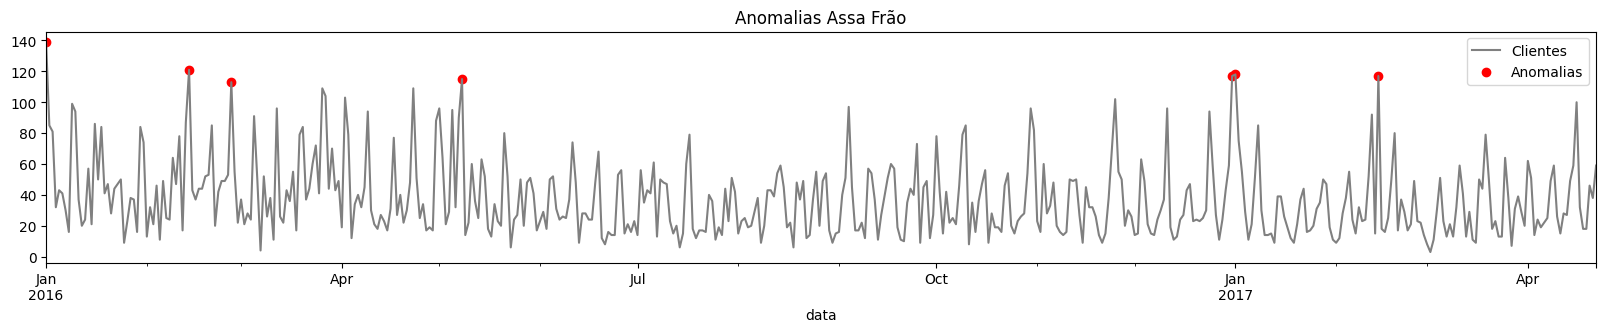

In [36]:
ax = dados['Assa Frão'].plot(label = 'Clientes', color = 'gray', figsize=(20, 3), title='Assa Frão')
ax.scatter(anomalias_assa_frao.index.to_pydatetime(), anomalias_assa_frao['Assa Frão'], color = 'red', label = 'Anomalias')
ax.set_title('Anomalias Assa Frão')
ax.legend();

Esta abordagem não apenas destaca as anomalias dentro da série temporal, mas também permite uma análise intuitiva da gravidade e da frequência das transações atípicas ao longo do tempo, facilitando a identificação de padrões ou eventos específicos que merecem atenção.

### Descobrindo as datas dos dados discrepantes

In [37]:
print('Anomalias Chimi & Churri')
display(anomalias_chimi_churri)
print('\n\n')
print('Anomalias Assa Frão')
display(anomalias_assa_frao)

Anomalias Chimi & Churri


,Chimi & Churri,zscore,dia_semana,feriado
data,,,,
2016-04-29,109,3.341710,Sexta-feira,NaN
2017-02-18,103,3.061475,Sábado,NaN
2017-03-11,128,4.229120,Sábado,NaN





Anomalias Assa Frão


,Assa Frão,zscore,dia_semana,feriado
data,,,,
2016-01-01,139,4.119717,Sexta-feira,Ano novo
2016-02-14,121,3.387830,Domingo,Dia dos namorados
2016-02-27,113,3.062546,Sábado,NaN
2016-05-08,115,3.143867,Domingo,Dia das maes
2016-12-31,117,3.225188,Sábado,Vespera de ano novo
2017-01-01,118,3.265848,Domingo,Ano novo
2017-02-14,117,3.225188,Terça-feira,Dia dos namorados


### Visualizando a autocorrelação

Text(0.5, 0.98, 'Autocorrelação Chimi & Churri')

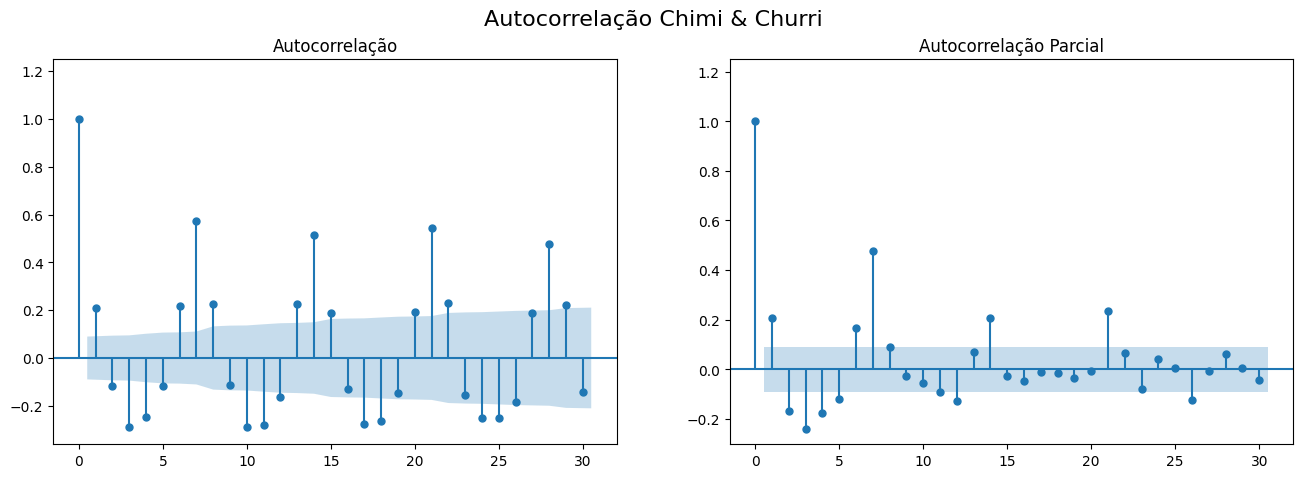

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(dados['Chimi & Churri'], lags = 30, title='Autocorrelação', auto_ylims=True, ax=axes[0])
plot_pacf(dados['Chimi & Churri'], lags = 30, title='Autocorrelação Parcial', auto_ylims=True, ax=axes[1])
plt.suptitle('Autocorrelação Chimi & Churri', fontsize=16)

Text(0.5, 0.98, 'Autocorrelação Assa Frão')

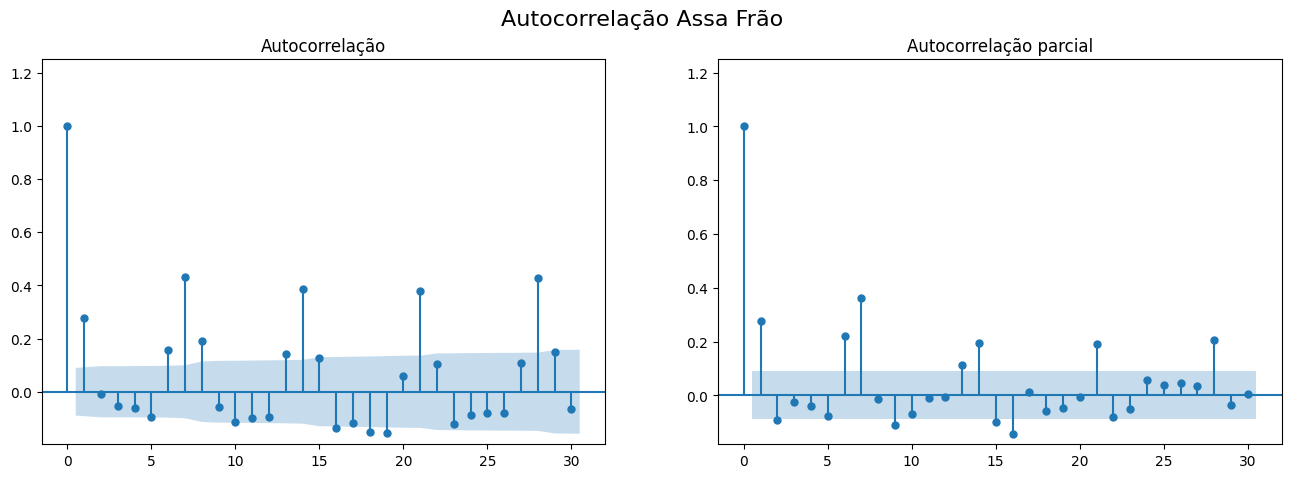

In [39]:
fig, axes = plt.subplots(1, 2, figsize = (16,5))
plot_acf(dados['Assa Frão'], lags = 30, title = 'Autocorrelação', auto_ylims = True, ax = axes[0])
plot_pacf(dados['Assa Frão'], lags = 30, title = 'Autocorrelação parcial', auto_ylims = True, ax = axes[1])
plt.suptitle('Autocorrelação Assa Frão', fontsize=16)

A cada semana se repete o mesmo padrão dos nossos dados. Se há uma alta quantidade de clientes, depois de 7 dias também haverá uma alta quantidade de clientes. Se houver uma baixa quantidade de clientes, a cada 7 dias haverá uma baixa quantidade de clientes também.

## Decomposição de uma série temporal

### Decompondo uma série de tempo

In [40]:
decomposicao_chimi_churri = seasonal_decompose(dados['Chimi & Churri'])

In [41]:
decomposicao_chimi_churri.trend

data
2016-01-01          NaN
2016-01-02          NaN
2016-01-03          NaN
2016-01-04    23.142857
2016-01-05    25.142857
                ...    
2017-04-18    42.857143
2017-04-19    46.857143
2017-04-20          NaN
2017-04-21          NaN
2017-04-22          NaN
Name: trend, Length: 478, dtype: float64

In [42]:
decomposicao_chimi_churri.seasonal

data
2016-01-01     8.129889
2016-01-02    32.114964
2016-01-03     4.912405
2016-01-04   -11.868229
2016-01-05   -10.796801
                ...    
2017-04-18   -10.796801
2017-04-19   -13.214868
2017-04-20    -9.277360
2017-04-21     8.129889
2017-04-22    32.114964
Name: seasonal, Length: 478, dtype: float64

In [43]:
decomposicao_chimi_churri.resid

data
2016-01-01          NaN
2016-01-02          NaN
2016-01-03          NaN
2016-01-04    11.725372
2016-01-05   -12.346056
                ...    
2017-04-18    -2.060342
2017-04-19   -13.642275
2017-04-20          NaN
2017-04-21          NaN
2017-04-22          NaN
Name: resid, Length: 478, dtype: float64

### Visualizando a decomposição da série temporal

In [44]:
def plot_decomposicao(decomposicao, title):
    fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex=True,figsize = (16, 10))
    decomposicao.observed.plot(ax = axes[0], title = 'Dados observados')
    decomposicao.trend.plot(ax = axes[1], title = 'Tendência')
    decomposicao.seasonal.plot(ax = axes[2], title = 'Sazonalidade')
    decomposicao.resid.plot(ax = axes[3], title = 'Resíduos')
    fig.suptitle(title)
    plt.show()

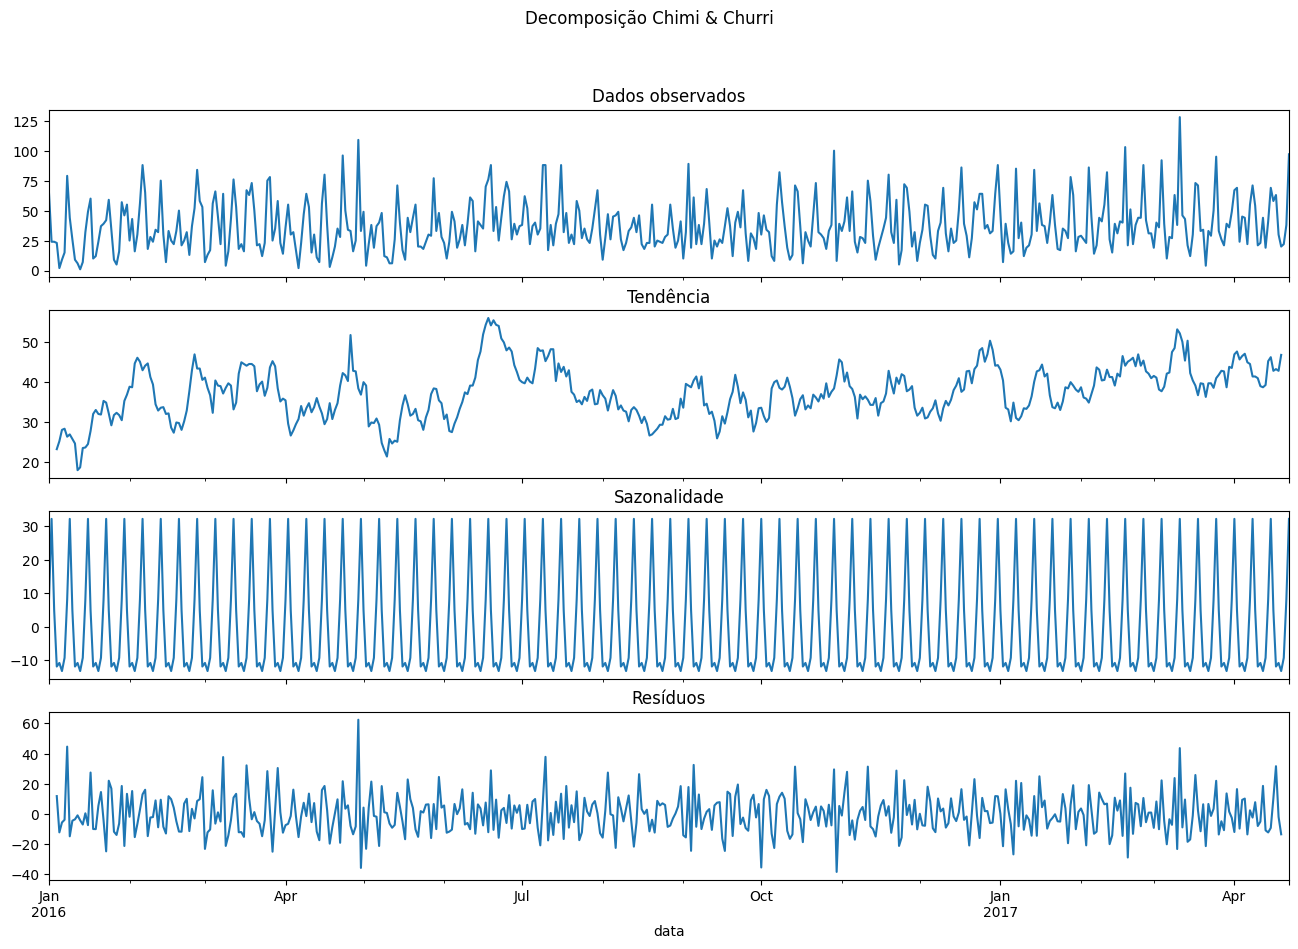

In [45]:
plot_decomposicao(decomposicao_chimi_churri, 'Decomposição Chimi & Churri')

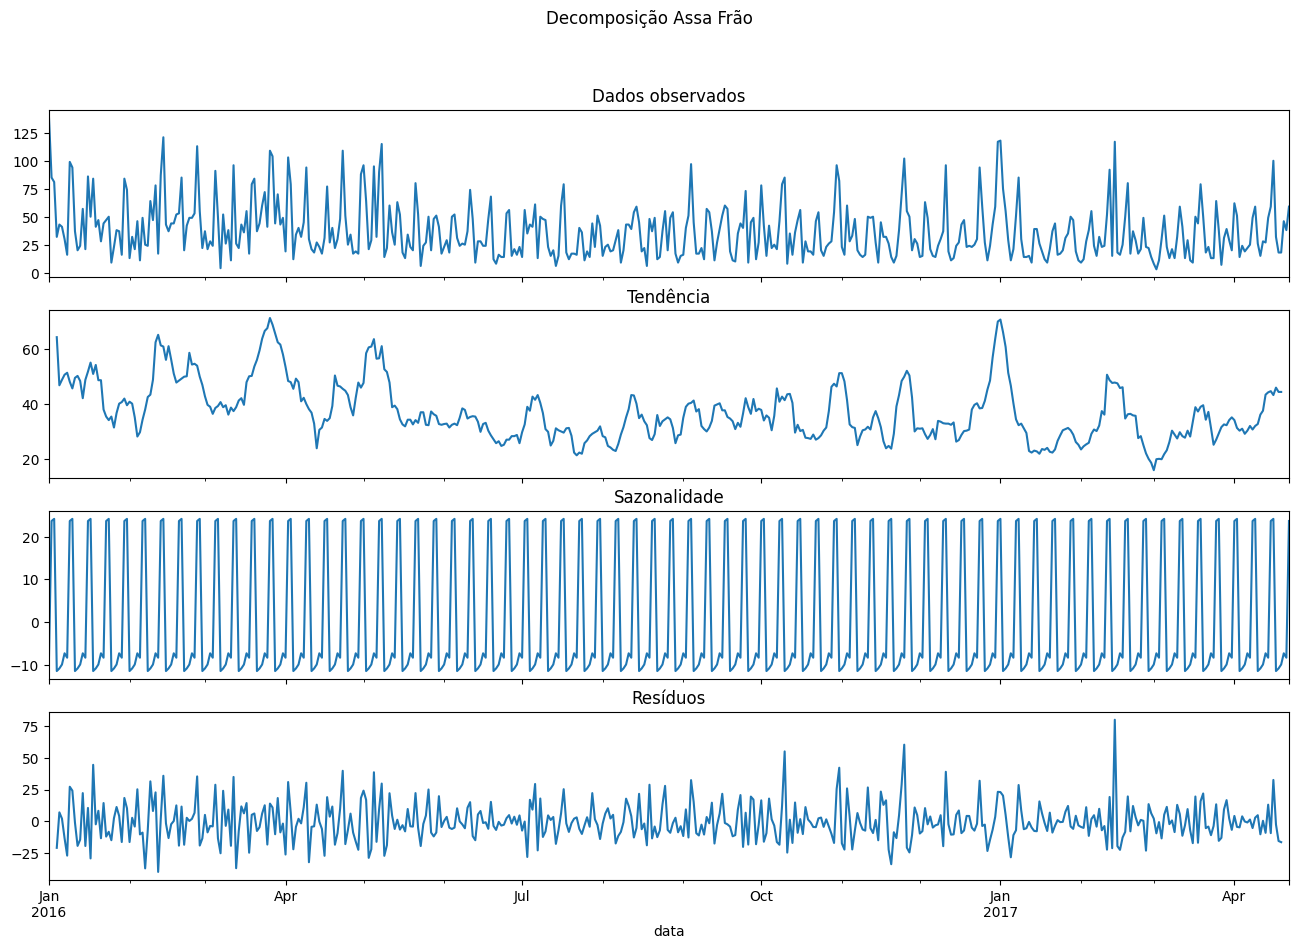

In [46]:
decomposicao_assa_frao = seasonal_decompose(dados['Assa Frão'])
plot_decomposicao(decomposicao_assa_frao, 'Decomposição Assa Frão')

As duas abordagens são **complementares** e cada uma tem suas vantagens:

- **Autocorrelação:**  
É melhor para **detectar dependências temporais** e identificar **lags** (defasagens) em que os dados estão correlacionados consigo mesmos. Ela mostra claramente se há padrões repetitivos em intervalos específicos (ex: semanal, mensal) e ajuda a escolher parâmetros para modelos de previsão.

- **Decomposição temporal:**  
É melhor para **visualizar e separar explicitamente os componentes** da série (tendência, sazonalidade e ruído). Ela facilita a interpretação dos padrões sazonais e de tendência, mostrando como cada componente contribui para a série.

**Resumo:**  
- Use **autocorrelação** para identificar lags importantes e dependências temporais.
- Use **decomposição** para visualizar e entender a estrutura dos padrões (tendência e sazonalidade).

O ideal é usar **ambas** em conjunto para uma análise completa de séries temporais.

### Checando anomalias de acordo com resíduos

In [47]:
anomalias_resid_chimi_churri = np.where(np.abs(decomposicao_chimi_churri.resid) > 2.5 *np.std(decomposicao_chimi_churri.resid))
anomalias_resid_chimi_churri

(array([  7,  67, 119, 120, 191, 274, 303, 435]),)

In [54]:
anomalias_resid_chimi_churri = dados.iloc[anomalias_resid_chimi_churri][['Chimi & Churri', 'dia_semana', 'feriado']]
anomalias_resid_chimi_churri

,Chimi & Churri,dia_semana,feriado
data,,,
2016-01-08,79,Sexta-feira,NaN
2016-03-08,64,Terça-feira,NaN
2016-04-29,109,Sexta-feira,NaN
2016-04-30,33,Sábado,NaN
2016-07-10,88,Domingo,NaN
2016-10-01,30,Sábado,NaN
2016-10-30,8,Domingo,NaN
2017-03-11,128,Sábado,NaN


C:\Users\mborges\AppData\Local\Temp\ipykernel_21324\4145737520.py:3: UserWarning:

This axis already has a converter set and is updating to a potentially incompatible converter



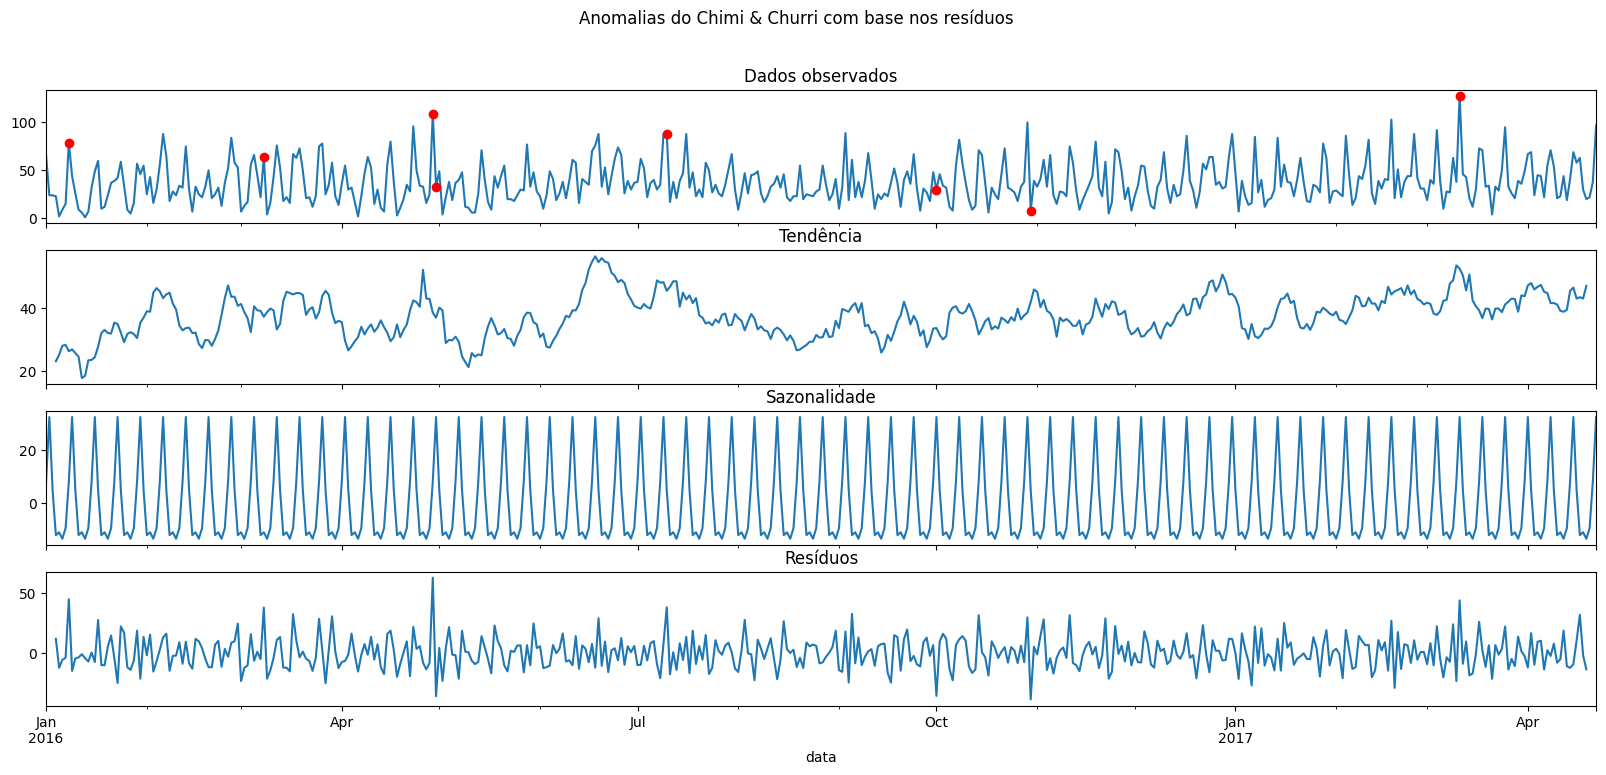

In [55]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex=True,figsize = (20, 8))
decomposicao_chimi_churri.observed.plot(ax = axes[0], title = 'Dados observados')
axes[0].plot(anomalias_resid_chimi_churri.index, anomalias_resid_chimi_churri['Chimi & Churri'], color = 'red', marker = 'o', linestyle = '', label = 'Anomalias')
decomposicao_chimi_churri.trend.plot(ax = axes[1], title = 'Tendência')
decomposicao_chimi_churri.seasonal.plot(ax = axes[2], title = 'Sazonalidade')
decomposicao_chimi_churri.resid.plot(ax = axes[3], title = 'Resíduos')
fig.suptitle('Anomalias do Chimi & Churri com base nos resíduos')
plt.show()

In [56]:
indices = np.where(np.abs(decomposicao_assa_frao.resid) > 2.5 * np.std(decomposicao_assa_frao.resid))[0]
anomalias_resid_assa_frao = dados.iloc[indices][['Assa Frão', 'dia_semana', 'feriado']]
anomalias_resid_assa_frao

,Assa Frão,dia_semana,feriado
data,,,
2016-01-18,84,Segunda-feira,NaN
2016-02-12,17,Sexta-feira,NaN
2016-04-23,109,Sábado,NaN
2016-05-05,95,Quinta-feira,NaN
2016-10-10,85,Segunda-feira,NaN
2016-10-31,82,Segunda-feira,Halloween
2016-11-25,102,Sexta-feira,Black Friday
2016-12-11,96,Domingo,NaN
2017-02-14,117,Terça-feira,Dia dos namorados


C:\Users\mborges\AppData\Local\Temp\ipykernel_21324\1140310398.py:3: UserWarning:

This axis already has a converter set and is updating to a potentially incompatible converter



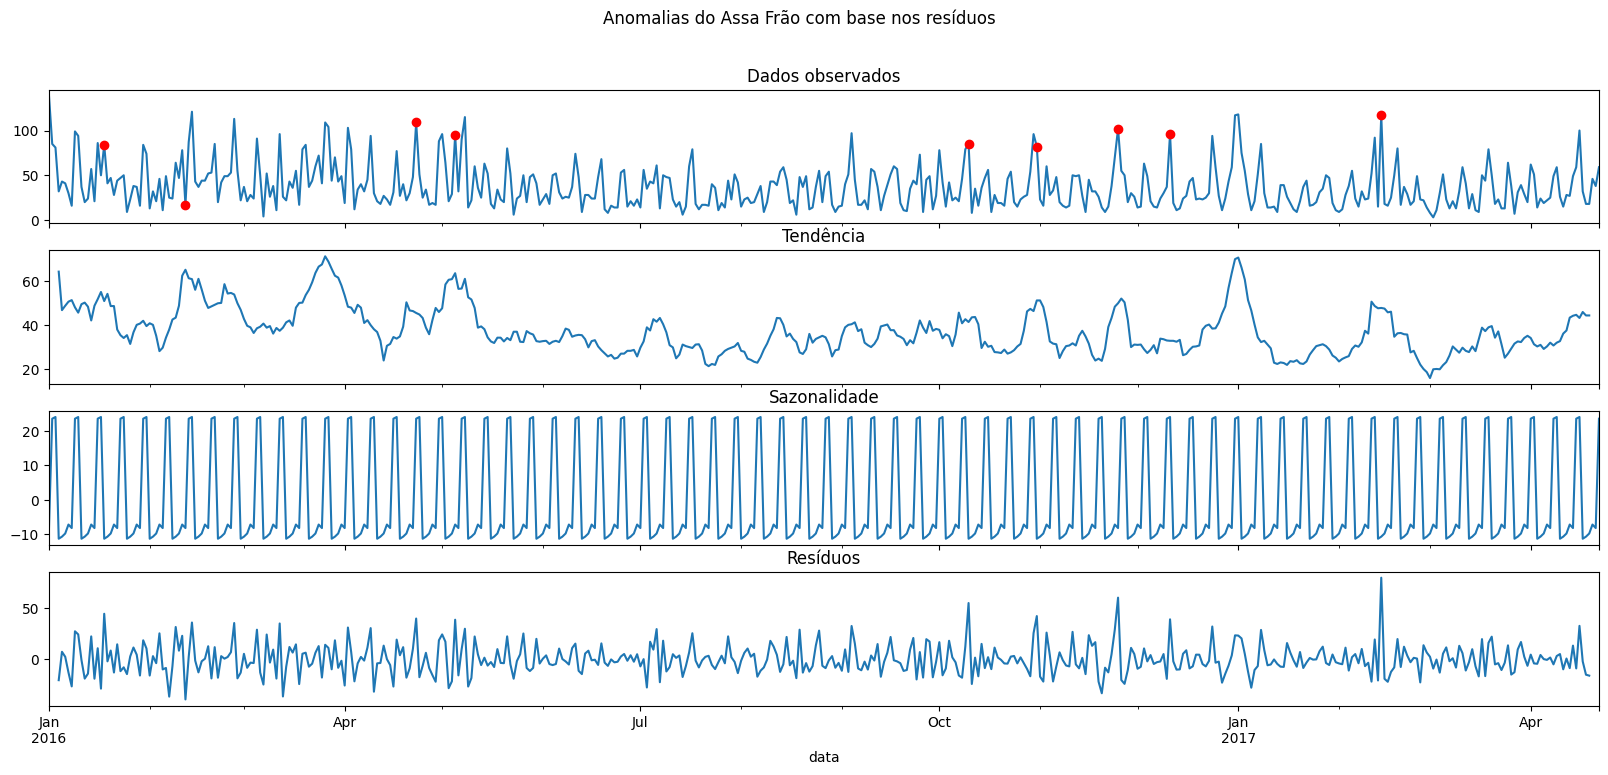

In [57]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex=True,figsize = (20, 8))
decomposicao_assa_frao.observed.plot(ax = axes[0], title = 'Dados observados')
axes[0].plot(anomalias_resid_assa_frao.index, anomalias_resid_assa_frao['Assa Frão'], color = 'red', marker = 'o', linestyle = '', label = 'Anomalias')
decomposicao_assa_frao.trend.plot(ax = axes[1], title = 'Tendência')
decomposicao_assa_frao.seasonal.plot(ax = axes[2], title = 'Sazonalidade')
decomposicao_assa_frao.resid.plot(ax = axes[3], title = 'Resíduos')
fig.suptitle('Anomalias do Assa Frão com base nos resíduos')
plt.show()

## Fazendo previsões de séries temporais

### Prevendo novos valores

Suavização exponencial de holtwinters

É importante fazer todas as análises que fizemos, porque assim conseguimos construir um modelo que satisfaz todas as condições.

In [59]:
modelo_chimi_churri = ExponentialSmoothing(dados['Chimi & Churri'], seasonal='additive', seasonal_periods=7, freq='D')
resultado_chimi_churri = modelo_chimi_churri.fit()
previsao_chimi_churri = resultado_chimi_churri.forecast(steps=14)

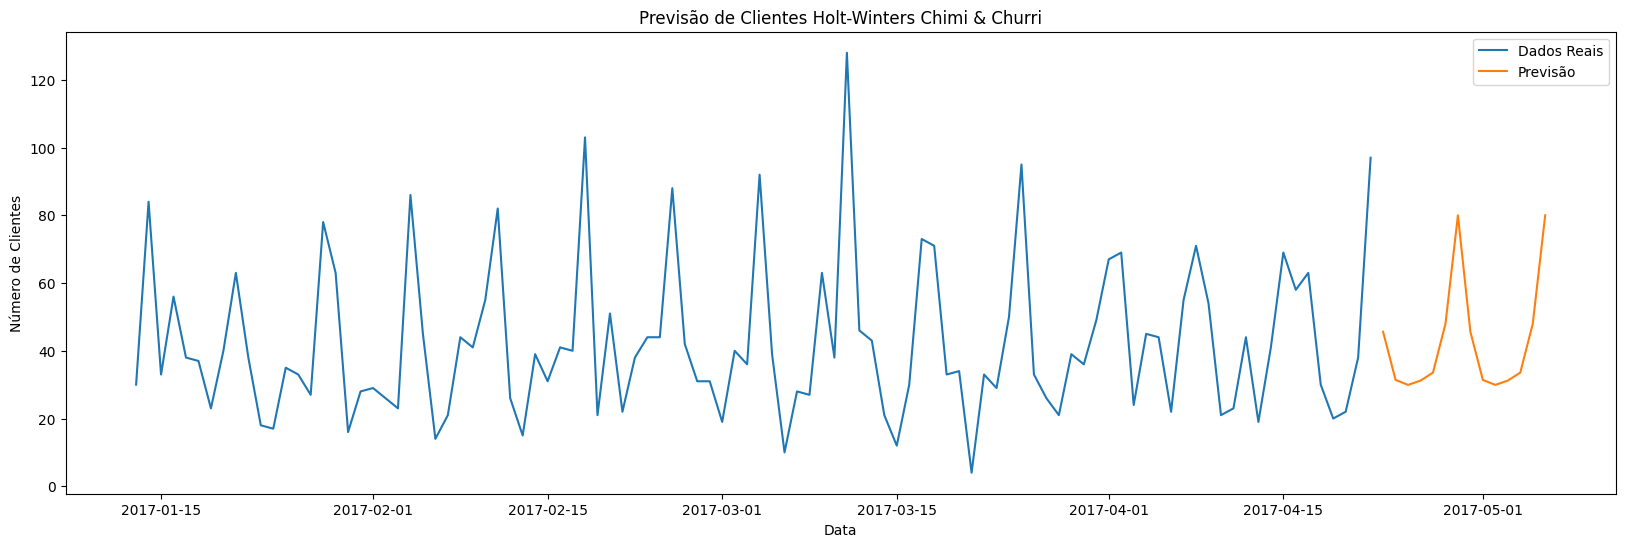

In [61]:
plt.figure(figsize = (20,6))
plt.plot(dados['Chimi & Churri'].index[-100:], dados['Chimi & Churri'].values[-100:], label='Dados Reais')
plt.plot(previsao_chimi_churri.index, previsao_chimi_churri.values, label='Previsão')
plt.title('Previsão de Clientes Holt-Winters Chimi & Churri')
plt.xlabel('Data')
plt.ylabel('Número de Clientes')
plt.legend()
plt.show()

In [62]:
modelo_assa_frao = ExponentialSmoothing(dados['Assa Frão'], seasonal = 'additive', seasonal_periods = 7, freq = 'D')
resultado_assa_frao = modelo_assa_frao.fit()
previsao_assa_frao = resultado_assa_frao.forecast(steps = 14)

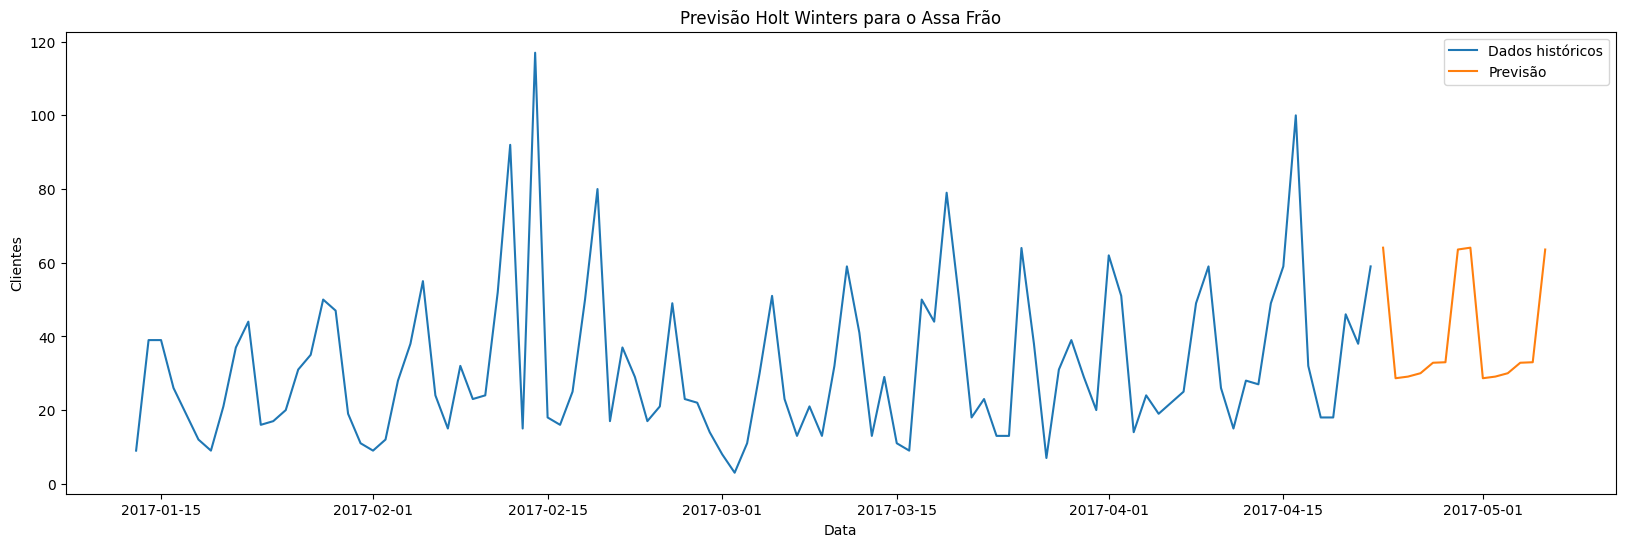

In [63]:
plt.figure(figsize = (20,6))
plt.plot(dados['Assa Frão'].index[-100:], dados['Assa Frão'].values[-100:], label = 'Dados históricos')
plt.plot(previsao_assa_frao.index, previsao_assa_frao.values, label = 'Previsão')
plt.title('Previsão Holt Winters para o Assa Frão')
plt.xlabel('Data')
plt.ylabel('Clientes')
plt.legend();

### Sumarizando as previsões

In [ ]:
tabela_previsao = pd.DataFrame()
tabela_previsao.index = previsao_chimi_churri.index
tabela_previsao['Chimi & Churri'] = previsao_chimi_churri.values
tabela_previsao['Assa Frão'] = previsao_assa_frao.values
tabela_previsao

,Chimi & Churri,Assa Frão
Data,,
2017-04-23,45.615042,64.083659
2017-04-24,31.404129,28.646837
2017-04-25,29.933185,29.092343
2017-04-26,31.187987,30.008440
2017-04-27,33.558200,32.851045
2017-04-28,47.912801,32.986936
2017-04-29,80.001121,63.585406
2017-04-30,45.615042,64.083659
2017-05-01,31.404129,28.646837


In [66]:
tabela_previsao = tabela_previsao.astype(int)
tabela_previsao

,Chimi & Churri,Assa Frão
Data,,
2017-04-23,45,64
2017-04-24,31,28
2017-04-25,29,29
2017-04-26,31,30
2017-04-27,33,32
2017-04-28,47,32
2017-04-29,80,63
2017-04-30,45,64
2017-05-01,31,28
